___
## Drug reviews -  UCI dataset
___
This is a problem involving drug reviews done by patients and the main goal is to predict the drug name based on the patient's condition.
The original dataset is available on the following website: https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29

The raw data is processed by using the Python script called **preprocessing.py** available in the same directory where this notebook is located.

Data Set Information:

The dataset provides patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction. The data was obtained by crawling online pharmaceutical review sites. The intention was to study

(1) sentiment analysis of drug experience over multiple facets, i.e. sentiments learned on specific aspects such as effectiveness and side effects,
(2) the transferability of models among domains, i.e. conditions, and
(3) the transferability of models among different data sources (see 'Drug Review Dataset (Druglib.com)').

The data is split into a train (75%) a test (25%) partition (see publication) and stored in two .tsv (tab-separated-values) files, respectively.

Attribute Information:

1. drugName (categorical): name of drug
2. condition (categorical): name of condition
3. review (text): patient review
4. rating (numerical): 10 star patient rating
5. date (date): date of review entry
6. usefulCount (numerical): number of users who found review useful

In [1]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import re
import os
import spacy
import numpy as np
import pandas as pd
import seaborn as sns 
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from spacy.lang.en import stop_words
from transformers import BertTokenizer, AutoTokenizer
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')

In [3]:
execution = 'Colab'

In [4]:
if execution == 'Colab':
  from google.colab import drive
  drive.mount('/content/drive')
  train_processed = pd.read_csv('/content/drive/MyDrive/datasets/drugsComTrain_processed.csv')
  test_processed = pd.read_csv('/content/drive/MyDrive/datasets/drugsComTest_processed.csv')
else:
  train_processed = pd.read_csv('./drugsCom_raw/drugsComTrain_processed.csv', index_col=0)
  test_processed = pd.read_csv('./drugsCom_raw/drugsComTest_processed.csv', index_col=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
print(tf.__version__)

2.12.0


In [6]:
# Verificar se há dispositivos GPU disponíveis
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    # Executando em um ambiente de GPU
    print("Rodando na GPU")
    # Acessar informações sobre a GPU
    for gpu in gpus:
        print("Nome do dispositivo:", gpu.name)
else:
    # Executando na CPU
    print("Rodando na CPU")

Rodando na GPU
Nome do dispositivo: /physical_device:GPU:0


In [7]:
train_processed = train_processed[pd.notna(train_processed['review'])]
test_processed = test_processed[pd.notna(test_processed['review'])]

In [8]:
train_processed.head(2)

,Unnamed: 0.1,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,0,206461,Valsartan,Left Ventricular Dysfunction,effect combination bystolic mg fish oil,9.0,"May 20, 2012",27
1,1,95260,Guanfacine,ADHD,son halfway fourth week intuniv concerned begi...,8.0,"April 27, 2010",192


In [9]:
test_processed.head(2)

,Unnamed: 0.1,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,0,163740,Mirtazapine,Depression,try antidepressant year citalopram fluoxetine ...,10.0,"February 28, 2012",22
1,1,206473,Mesalamine,"Crohn's Disease, Maintenance",son disease asacol complaint effect tablet day...,8.0,"May 17, 2009",17


#### Checking the distribuition of the words

In this case, the main words are commom words (more generic), which means, it's possible to use a pretrained model.

In [10]:
sentences = list(train_processed['review'])

In [11]:
from wordcloud import WordCloud, STOPWORDS

def nuvem_palavras(df: pd.DataFrame, col:str, stop_words: list):
    palavras = df.dropna(subset=col, axis=0)[col]
    
    todas_palavras = " ".join(s for s in palavras)
   
    wordcloud = WordCloud(background_color="black", 
                          width=1600, height=800).generate(todas_palavras)
    
    fig, ax = plt.subplots(figsize=(15,9))
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_axis_off()

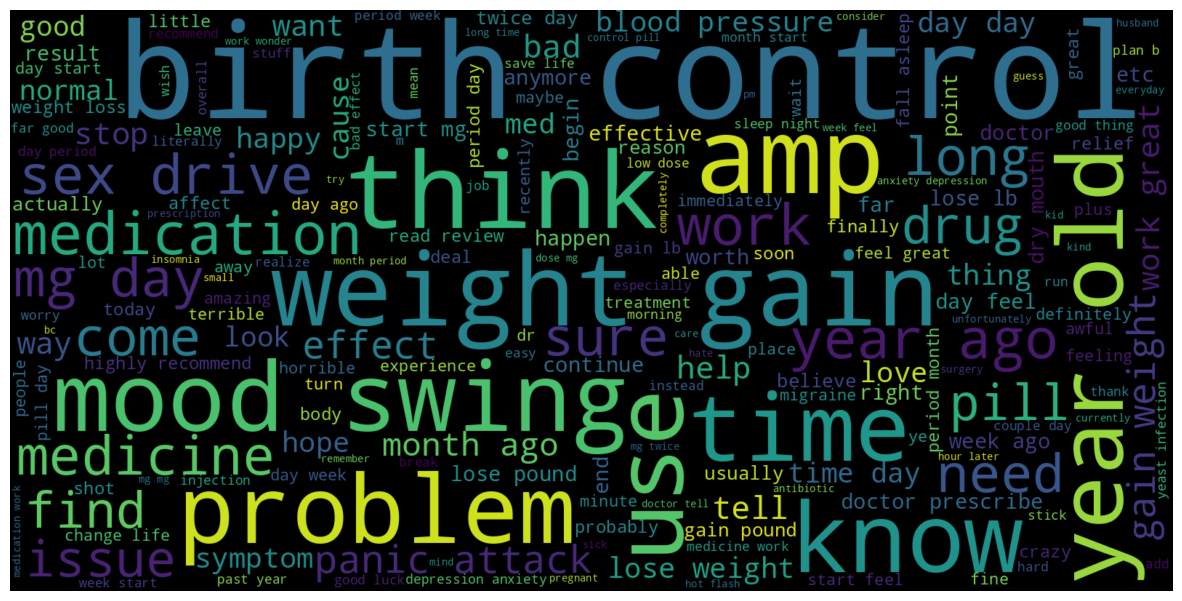

In [12]:
stop_words = STOPWORDS
nuvem_palavras(train_processed, 'review', stop_words)

#### Checking the amount of the stopwords

In [13]:
word_count = {}
for sentence in sentences:
    words = sentence.lower().split()
    for word in words:
        if word in stop_words:
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1

df = pd.DataFrame({'Stopword': list(word_count.keys()), 'Count': list(word_count.values())}).sort_values('Count', ascending=False)

In [14]:
df

,Stopword,Count
0,like,42714
2,having,893
1,shall,110
3,r,102
6,k,37
5,theirs,18
4,ought,15
7,com,2


In [15]:
# Top 5
train_processed['condition'].value_counts(normalize=True)[:5]*100

Birth Control    17.951436
Depression        5.652694
Pain              3.830612
Anxiety           3.677837
Acne              3.483906
Name: condition, dtype: float64

In [16]:
train_filtered = train_processed[(train_processed['condition'] == 'Birth Control') | 
                                 (train_processed['condition'] == 'Depression') |
                                 (train_processed['condition'] == 'Pain') |
                                 (train_processed['condition'] == 'Anxiety') |
                                 (train_processed['condition'] == 'Acne')]

In [17]:
test_filtered = test_processed[(test_processed['condition'] == 'Birth Control') | 
                               (test_processed['condition'] == 'Depression') |
                               (test_processed['condition'] == 'Pain') |
                               (test_processed['condition'] == 'Anxiety') |
                               (test_processed['condition'] == 'Acne')]

In [18]:
condition_dict = {}

for n, i in enumerate(train_filtered.condition.unique()):
    condition_dict[i] = n

In [19]:
train_filtered.condition = train_filtered.condition.map(condition_dict)
test_filtered.condition = test_filtered.condition.map(condition_dict)

In [20]:
sentences = list(train_filtered['review'])

In [21]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [22]:
train_filtered['tokens'] = train_filtered['review'].apply(lambda x: tokenizer(x)['input_ids'])
test_filtered['tokens'] = test_filtered['review'].apply(lambda x: tokenizer(x)['input_ids'])

The tokenizer brings the word ‘bystolic’ incomplete. it can handle most of the unknown words and improve the model accuracy. 

In [23]:
epochs = 2
num_classes = 5
max_length = 10
vocab_size = 30522
embedding_dim = 768

In [24]:
all_tokens = [i for i in train_filtered.tokens]
all_tokens_test = [i for i in test_filtered.tokens]

In [25]:
class MyModel(keras.Model):
  def __init__(self, vocab_size, embedding_dim, num_classes, max_length):
    super(MyModel, self).__init__()
    self.embed = Embedding(vocab_size, embedding_dim, input_length=max_length)
    self.lstm = LSTM(64, return_sequences=False)
    self.dense = Dense(num_classes, activation='softmax')

  def call(self, input_tensor):
    x = self.embed(input_tensor)
    x = self.lstm(x)
    x = self.dense(x)
    return x

In [26]:
X_train = pad_sequences(all_tokens, maxlen=max_length)
y_train = np.array(train_filtered.condition).reshape((-1, 1))
X_test = pad_sequences(all_tokens_test, maxlen=max_length)
y_test = np.array(test_filtered.condition).reshape((-1, 1))

In [27]:
# Batch_size precisa ser múltiplo do número de observações do conjunto de treinamento
model = MyModel(vocab_size=vocab_size,
                embedding_dim=embedding_dim, 
                num_classes=num_classes, 
                max_length=max_length)

In [29]:
batch_size = 32

In [30]:
# Creating datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

In [31]:
optimizer = keras.optimizers.Adam() 
loss_fn = keras.losses.SparseCategoricalCrossentropy()

In [32]:
# Loop de treinamento
for epoch in range(epochs):
    # Inicializar as métricas
    train_loss = keras.metrics.Mean()
    train_accuracy = keras.metrics.SparseCategoricalAccuracy()

    # Loop através dos lotes de treinamento
    for x_batch_train, y_batch_train in train_dataset:
        # Calcular os gradientes dentro de um contexto de gravação de gradientes
        with tf.GradientTape() as tape:
            # Obter as previsões do modelo
            y_pred = model(x_batch_train, training=True)
            # Calcular a perda
            loss_value = loss_fn(y_batch_train, y_pred)

        # Calcular gradientes
        grads = tape.gradient(loss_value, model.trainable_variables)
        # Atualizar os pesos do modelo
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Atualizar as métricas
        train_loss(loss_value)
        train_accuracy(y_batch_train, y_pred)

    # Imprimir métricas de treinamento ao final de cada época
    print(f"Epoch {epoch + 1}: Loss = {train_loss.result()}, Accuracy = {train_accuracy.result()}")

# Avaliar o modelo em um conjunto de teste (opcional)
test_loss = keras.metrics.Mean()
test_accuracy = keras.metrics.SparseCategoricalAccuracy()
for x_batch_test, y_batch_test in test_dataset:
    y_pred = model(x_batch_test, training=False)
    loss_value = loss_fn(y_batch_test, y_pred)
    test_loss(loss_value)
    test_accuracy(y_batch_test, y_pred)

print(f"Test Loss: {test_loss.result()}, Test Accuracy: {test_accuracy.result()}")

Epoch 1: Loss = 0.5839775204658508, Accuracy = 0.7869541049003601
Epoch 2: Loss = 0.4044618606567383, Accuracy = 0.8560408353805542
Test Loss: 0.4816335439682007, Test Accuracy: 0.8322847485542297


In [33]:
model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    optimizer = keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [34]:
# Inicializar as métricas
test_loss = 0.0
test_accuracy = 0.0
num_batches = 0

# Loop sobre o conjunto de teste
for x_batch, y_batch in test_dataset:
    # Calcular as métricas para o lote atual
    loss, accuracy = model.evaluate(x_batch, y_batch)
    
    # Acumular as métricas
    test_loss += loss
    test_accuracy += accuracy
    num_batches += 1

# Calcular as métricas médias
test_loss /= num_batches
test_accuracy /= num_batches

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 [==============================] - 0s 438ms/step - loss: 1.3002 - accuracy: 0.6000
Test Loss: 0.4816335733096624
Test Accuracy: 0.8319480240959483


In [35]:
previsoes = model.predict(test_dataset, batch_size=batch_size, verbose=2)

582/582 - 1s - 1s/epoch - 2ms/step


In [43]:
# Aplicando um limiar de 0.5 para obter valores binários
class_predictions = np.argmax(previsoes, axis=1)

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [47]:
# Gerando o relatório de classificação
report = classification_report(y_test, class_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      9648
           1       0.71      0.73      0.72      3095
           2       0.75      0.85      0.80      2100
           3       0.68      0.54      0.60      1908
           4       0.82      0.77      0.79      1846

    accuracy                           0.83     18597
   macro avg       0.78      0.77      0.77     18597
weighted avg       0.83      0.83      0.83     18597



In [48]:
# Criando a matriz de confusão
cm = confusion_matrix(y_test, class_predictions)

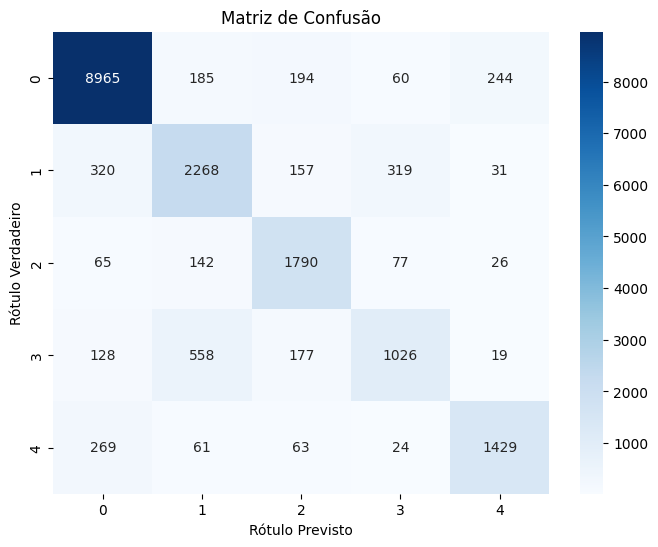

In [49]:
# Configurando o gráfico de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão")
plt.xlabel("Rótulo Previsto")
plt.ylabel("Rótulo Verdadeiro")
plt.show()

### References 

https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/42_word2vec_gensim/42_word2vec_gensim.ipynb

https://www.youtube.com/watch?v=30zPz5Xz-8g

https://www.youtube.com/watch?v=2VwPnQeZNMA&t=567s

https://www.analyticsvidhya.com/blog/2021/09/an-explanatory-guide-to-bert-tokenizer/